In [1]:
import torch as th
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pylab as pl


# Load train and test-set
train_set = DataLoader(datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()), 
                       batch_size=1024, shuffle=True)
test_set = DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), 
                      batch_size=1024, shuffle=False)

/home/wendelin/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wendelin/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Definition of accuracy for categorical data
def accuracy(mx, y):
    return (mx.max(dim=-1)[1] == y).sum().item() / len(y)

# One epoch of the model on test or traning data. If an optimizer is provided, perform gradient descent.
def epoch(data, model, optimizer=None):
    losses, accuracies = [], []
    for x, y in data:
        mx = model(x)
        loss = criterion(mx, y)
        if optimizer is not None: 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        accuracies.append(accuracy(mx, y))
    return np.mean(losses), np.mean(accuracies)

# Train the given model for n epochs
def train_model(model, n=10, lr=0.0005):
    optimizer = th.optim.RMSprop(model.parameters(), lr=lr)
    train_loss, train_acc = [], []
    loss, acc = epoch(test_set, model)
    test_loss, test_acc = [loss], [acc]
    # Main training loop
    print('Epoch ', end='')
    for e in range(n):
        print(e + 1, end=' ')
        # Train the model
        loss, acc = epoch(train_set, model, optimizer=optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        # Test the model
        loss, acc = epoch(test_set, model)
        test_loss.append(loss)
        test_acc.append(acc)
    print()
    return train_loss, train_acc, test_loss, test_acc

# Plots the loss and accuracy output of train_model()
def plot_learning_curves(train_loss, train_acc, test_loss, test_acc):
    def plot_series(train, test, ylabel=''):
        gca = plt.gca()
        gca.plot([i+1 for i in range(len(train))], train)
        gca.plot([i for i in range(len(test))], test)
        gca.legend(['train', 'test'])
        gca.set_xlabel('training epochs')
        gca.set_ylabel(ylabel)
    fig = plt.gcf()
    fig.set_size_inches(16, 4)
    pl.subplot(1, 2, 1)
    plot_series(train_loss, test_loss, 'loss')
    pl.subplot(1, 2, 2)
    plot_series(train_acc, test_acc, 'accuracy')

Epoch 1 2 3 4 5 6 7 8 9 10 


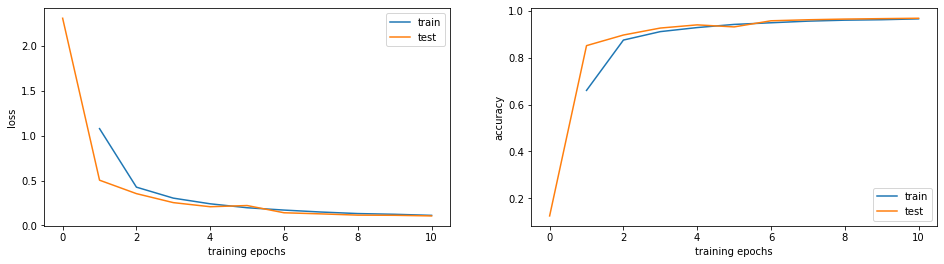

In [3]:
# A1.1 (a) ######################################################
# MNIST classification network from the lecture slides
def make_model():
    return th.nn.Sequential(th.nn.Conv2d(1, 8, 5),    # ( 8, 24, 24)
                            th.nn.ReLU(),             # ( 8, 24, 24)
                            th.nn.MaxPool2d(2, 2),    # ( 8, 12, 12)
                            th.nn.Conv2d(8, 16, 5),   # (16,  8,  8)
                            th.nn.ReLU(),             # (16,  8,  8)
                            th.nn.MaxPool2d(2, 2),    # (16,  4,  4)
                            th.nn.Flatten(),          # (16 * 4 * 4)
                            th.nn.Linear(256, 128),   # (128)
                            th.nn.ReLU(),             # (128)
                            th.nn.Linear(128, 32),    # ( 32)
                            th.nn.ReLU(),             # ( 32)
                            th.nn.Linear(32, 10))     # ( 10)

# Define cross-entropy optimization criterion
criterion = th.nn.CrossEntropyLoss()

# Train the model and plot
plot_learning_curves(*train_model(make_model()))

Epoch 1 2 3 4 5 6 7 8 9 10 


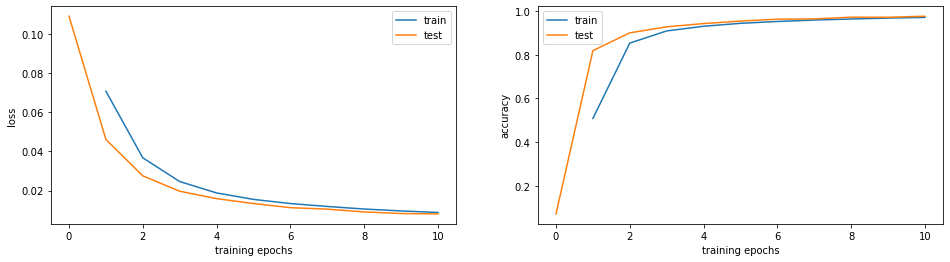

In [4]:
# A1.1 (b) #########################################################
# New cross-entropy optimization criterion
def criterion(mx, y):
    one_hot = th.zeros(*mx.shape).scatter_(dim=-1, index=y.unsqueeze(dim=-1), src=th.ones(1, 1).expand_as(mx))
    return th.nn.functional.mse_loss(mx, one_hot)

# Train the model and plot
plot_learning_curves(*train_model(make_model()))

Epoch 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 


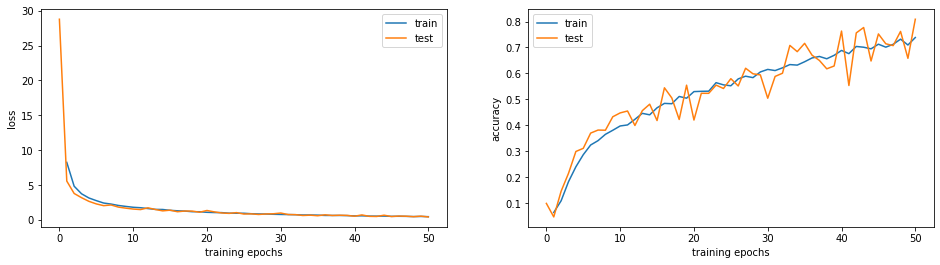

In [5]:
# A1.1 (c) #########################################################
# CNN for MNIST with one onput neuron
def make_model():
    return th.nn.Sequential(th.nn.Conv2d(1, 8, 5),    # ( 8, 24, 24)
                            th.nn.ReLU(),             # ( 8, 24, 24)
                            th.nn.MaxPool2d(2, 2),    # ( 8, 12, 12)
                            th.nn.Conv2d(8, 16, 5),   # (16,  8,  8)
                            th.nn.ReLU(),             # (16,  8,  8)
                            th.nn.MaxPool2d(2, 2),    # (16,  4,  4)
                            th.nn.Flatten(),          # (16 * 4 * 4)
                            th.nn.Linear(256, 128),   # (128)
                            th.nn.ReLU(),             # (128)
                            th.nn.Linear(128, 32),    # ( 32)
                            th.nn.ReLU(),             # ( 32)
                            th.nn.Linear(32, 1))      # (  1)

# Transformation function for (d)
move, scale = 0, 1
def trans(x):
    return x * scale + move

# New regression criterion (incl. transformation) for scalar predictions
def criterion(mx, y):
    return th.nn.functional.mse_loss(trans(mx.squeeze()), y.float())

# New accuracy definition (incl. transformation) for scalar predictions
def accuracy(mx, y):
    return ((trans(mx.squeeze()) - y.float()).abs() < 0.5).sum().item() / len(y)

# Train new model with new cirterion
plot_learning_curves(*train_model(make_model(), n=50))

Epoch 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 


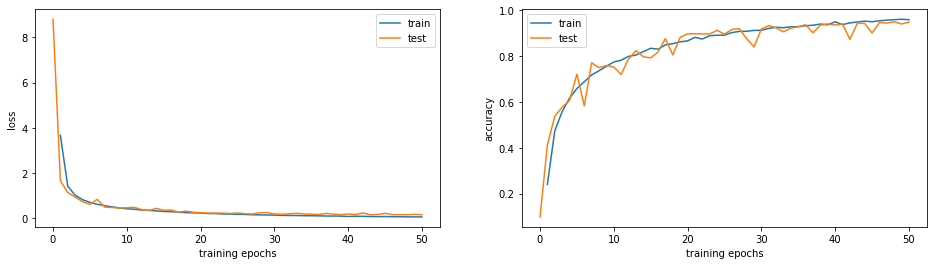

In [6]:
# A1.1 (d) #########################################################
move, scale = 4.5, 4.5
plot_learning_curves(*train_model(make_model(), n=50))